In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np
import uproot
import logging

import acts

from itertools import cycle

import awkward as ak

from gnn4itk_tools.detector_plotter import DetectorPlotter

[W interface.cpp:47] Warning: Loading nvfuser library failed with: Error in dlopen: libnvfuser_codegen.so: cannot open shared object file: No such file or directory (function LoadingNvfuserLibrary)


In [2]:
match_df = pd.read_csv("../tmp/no_threshold_2/performance_gnn_plus_ckf.csv", dtype={"particle_id": np.uint64})
match_df = match_df[ match_df.event == 0 ].copy()

In [3]:
particles = ak.to_dataframe(uproot.open("../tmp/simdata/particles_initial.root:particles").arrays(), how="inner").reset_index(drop=True)
particles = particles[ particles.event_id == 0 ].copy()
particles = particles[ particles.particle_id.isin(match_df.particle_id) ].copy()
particles.shape

(887, 22)

In [4]:
particles["matched"] = particles.particle_id.map(dict(zip(match_df.particle_id, match_df.matched)))
assert not any(pd.isna(particles.matched))
particles.head(2)

,event_id,particle_id,particle_type,process,vx,vy,vz,vt,px,py,...,eta,phi,pt,p,vertex_primary,vertex_secondary,particle,generation,sub_particle,matched
2,0,4503599677702144,-211,0,-0.006878,0.006443,26.299278,0.0,1.618853,-0.872867,...,-1.899954,-0.494505,1.839180,6.28555,1,0,3,0,0,1
3,0,4503599694479360,321,0,-0.006878,0.006443,26.299278,0.0,-0.340527,-1.401685,...,-3.243134,-1.809120,1.442456,18.50160,1,0,4,0,0,1


In [5]:
hits = uproot.open("../tmp/simdata/hits.root:hits").arrays(library="pd")
hits = hits[ (hits.event_id == 0) & (hits.tt < 25.0) ].copy()
hits["hit_id"] = np.arange(len(hits))
hits.head(2)

simhit_map = pd.read_csv("../tmp/no_threshold_2/digi/event000000000-measurement-simhit-map.csv")
measId_to_hitID = dict(zip(simhit_map.measurement_id, simhit_map.hit_id))
hitId_to_particleId = dict(zip(hits.hit_id, hits.particle_id))

def process_prototracks(tracks):
    tracks["hit_id"] = tracks["measurementId"].map(measId_to_hitID)
    tracks["tx"] = tracks.hit_id.map(dict(zip(hits.hit_id, hits.tx)))
    tracks["ty"] = tracks.hit_id.map(dict(zip(hits.hit_id, hits.ty)))
    tracks["tz"] = tracks.hit_id.map(dict(zip(hits.hit_id, hits.tz)))
    tracks["geometry_id"] = tracks.hit_id.map(dict(zip(hits.hit_id, hits.geometry_id)))
    tracks["particle_id"] = tracks.hit_id.map(hitId_to_particleId)
    return tracks

In [6]:
prototracks = pd.read_csv("../tmp/no_threshold_2/gnn_plus_ckf/event000000000-prototracks.csv")
prototracks = process_prototracks(prototracks)
gnn_prototracks = [ t for _, t in prototracks.groupby("trackId") ]
print("GNN prototracks:",len(gnn_prototracks))

GNN prototracks: 2819


In [7]:
true_prototracks = pd.read_csv("../tmp/no_threshold_2/proof_of_concept/event000000000-prototracks.csv")
true_prototracks = process_prototracks(true_prototracks)
true_prototracks = [ t for _, t in true_prototracks.groupby("trackId") ]
print("True prototracks:",len(true_prototracks))

True prototracks: 883


In [8]:
particles_eta_slice = particles[ particles.eta.between(-0.1,0.1) & (particles.matched == 0) ].reset_index()
len(particles_eta_slice)

1

In [9]:
prototracks_slice = [
    t for _, t in prototracks[ 
        prototracks.trackId.isin(
            np.unique(prototracks[ prototracks.particle_id.isin(particles_eta_slice.particle_id) ].trackId)
        )
    ].groupby("trackId") 
]
len(prototracks_slice)

0

In [10]:
graph = pd.read_csv("../tmp/no_threshold_2/gnn_plus_ckf/event000000000-exatrkx-graph.csv")
spacepoints = pd.read_csv("../tmp/no_threshold_2/digi/event000000000-spacepoint.csv")

for edge, poscols in [("edge0", ["x0","y0","z0"]), ("edge1", ["x1","y1","z1"])]:
    for c in poscols:
        graph[c] = graph[edge].map(dict(zip(spacepoints.measurement_id, spacepoints[c[:1]])))

graph["r0"] = np.hypot(graph.x0, graph.y0)
graph["r1"] = np.hypot(graph.x1, graph.y1)

graph.head(3)

,edge0,edge1,weight,x0,y0,z0,x1,y1,z1,r0,r1
0,5,2340,0.999589,98.324997,5.225,-1515.59998,85.474998,5.275000,-1315.59998,98.463728,85.637614
1,13,2348,0.999716,63.224998,-3.725,-1515.59998,54.775002,-3.575001,-1315.59998,63.334636,54.891542
2,14,83,0.999962,63.825001,7.225,-1515.59998,63.886929,7.205680,-1516.80005,64.232635,64.292002


In [11]:
particles_not_matched = particles[ particles.matched == 0 ].reset_index()
len(particles_not_matched)

61

In [12]:
prototracks_all_not_matched = [
    t for _, t in prototracks[ 
        prototracks.trackId.isin(
            np.unique(prototracks[ prototracks.particle_id.isin(particles_not_matched.particle_id) ].trackId)
        )
    ].groupby("trackId") 
]

In [13]:
prototracks_all_not_matched = sorted(prototracks_all_not_matched, key=lambda t: len(t))

In [18]:
import networkx as nx
from networkx.algorithms.connectivity.edge_kcomponents import bridge_components


In [19]:
def draw_abstract_graph(ax, g, mark_edges=None, node_size=200, mark_core=True):    
    tab_colors = matplotlib.colors.TABLEAU_COLORS.copy()
    del tab_colors["tab:red"]
    del tab_colors["tab:green"]

    measId_to_particleId = dict(zip(thistrack.measurementId, thistrack.particle_id))
    particleId_to_color = dict(zip(np.unique(thistrack.particle_id), tab_colors))
    measId_to_color = { m: particleId_to_color[ measId_to_particleId[ m ] ] for m in thistrack.measurementId }
    
    g_core = nx.k_core(g, k=2)
    ug = g #nx.Graph()
    
    #for u,v in g.edges:
        #ug.add_edge(u, v, **g[u][v])
        
    edges = list(ug.edges())
    colors = [ug[u][v]['color'] for u,v in edges]
    weights = np.array([ug[u][v]['weight'] for u,v in edges])
    
    #if mark_core:
    #    styles = [ '-' if (u,v) in g_core.edges() or (v,u) in g_core.edges() else ':' for u,v in edges ]
    #else:
    styles = '-'
    
    if mark_edges is not None:
        for i in range(len(edges)):
            u, v = edges[i]
            if (u,v) in mark_edges or (v,u) in mark_edges:
                colors[i] = "blue"
    
    pos = nx.kamada_kawai_layout(ug)
    #pos = nx.spring_layout(g, k=0.5)

    nx.draw_networkx_nodes(ug, pos=pos, node_size=node_size, 
                           node_color=[ measId_to_color[n] for n in ug.nodes() ], edgecolors="black", ax=ax)
    
    nx.draw_networkx_edges(ug, pos=pos, edge_color=colors, width=np.exp(2.5*(weights-0.4))/1.5 + 0.4, 
                           connectionstyle='arc3, rad = 0.2', ax=ax, arrowstyle='-|>', arrows=True, style=styles)

/tmp/ipykernel_75110/3504350596.py:37: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(ug, pos=pos, edge_color=colors, width=np.exp(2.5*(weights-0.4))/1.5 + 0.4,


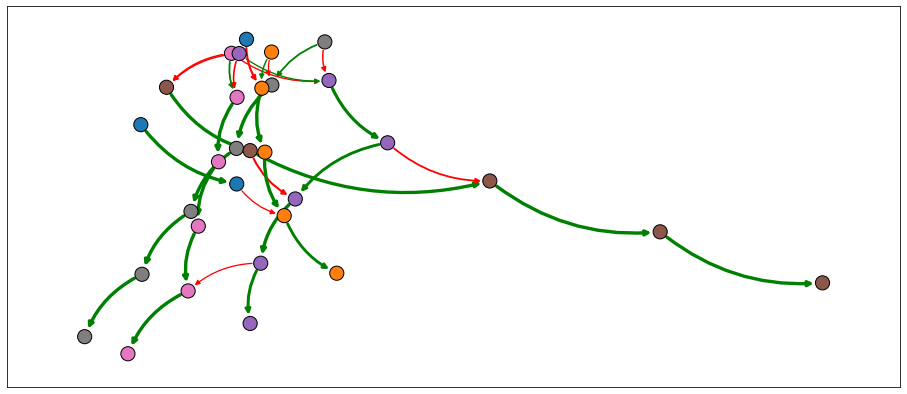

In [20]:
thistrack = prototracks_all_not_matched[-1]
thisgraph = graph[ graph.edge0.isin(thistrack.measurementId) | graph.edge1.isin(thistrack.measurementId) ].copy()

g = nx.DiGraph()

for _, row in thisgraph.iterrows():
    try:
        good_edge = (
            thistrack[ thistrack.measurementId == row.edge0 ].particle_id.iloc[0] == 
            thistrack[ thistrack.measurementId == row.edge1 ].particle_id.iloc[0]
        )
        color="green" if good_edge else "red"
    except:
        color='black'
    if row.r0 < row.r1:
        g.add_edge(row.edge0, row.edge1, color=color, weight=row.weight)
    else:
        g.add_edge(row.edge1, row.edge0, color=color, weight=row.weight)

plt.figure(figsize=(16,7))
draw_abstract_graph(plt.gca(), g)

could not remove edge
could not remove edge
could not remove edge
could not remove edge
could not remove edge
could not remove edge
could not remove edge


/tmp/ipykernel_75110/3504350596.py:37: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(ug, pos=pos, edge_color=colors, width=np.exp(2.5*(weights-0.4))/1.5 + 0.4,


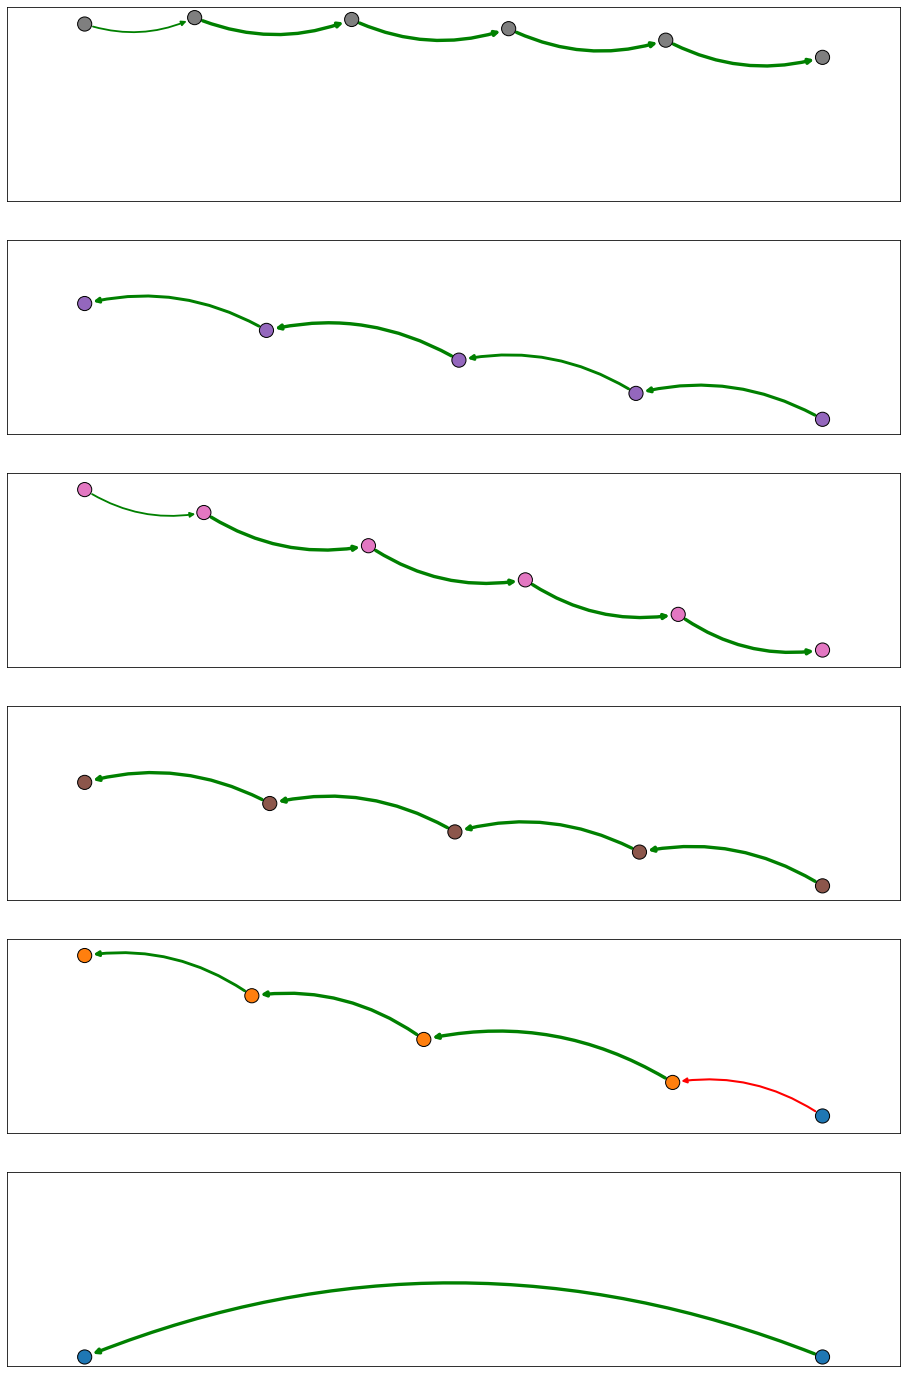

In [21]:
gnew = g.copy()
            

for n in g.nodes:
    if g.out_degree[n] > 1:
        maxw = max([ g[u][v]["weight"] for u,v in g.out_edges(n) ])
        for u,v in g.out_edges(n):
            if g[u][v]["weight"] < maxw:
                try:
                    gnew.remove_edge(u,v)
                except:
                    print("could not remove edge")
                
    if g.in_degree[n] > 0:
        maxw = max([ g[u][v]["weight"] for u,v in g.in_edges(n) ])
        for u,v in g.in_edges(n):
            if g[u][v]["weight"] < maxw:
                try:
                    gnew.remove_edge(u,v)
                except:
                    print("could not remove edge")
        
            

def inherit_direction(subg):
    newsub = nx.DiGraph()
    for u,v in subg.edges():
        if (u,v) in g.edges():
            newsub.add_edge(u,v,**subg[u][v])
        else:
            newsub.add_edge(v,u,**subg[u][v])
            
    return newsub
        
subs = [ inherit_direction(gnew.subgraph(c)) for c in nx.weakly_connected_components(gnew) ]
subs = [ s for s in subs if len(s) > 1 ]
fig, ax = plt.subplots(len(subs), figsize=(16,25))

for a, s in zip(ax, subs):
    draw_abstract_graph(a, s)